In [6]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [7]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [9]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:



In [10]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [11]:
X_new = np.array([[0.8]])

In [12]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [13]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

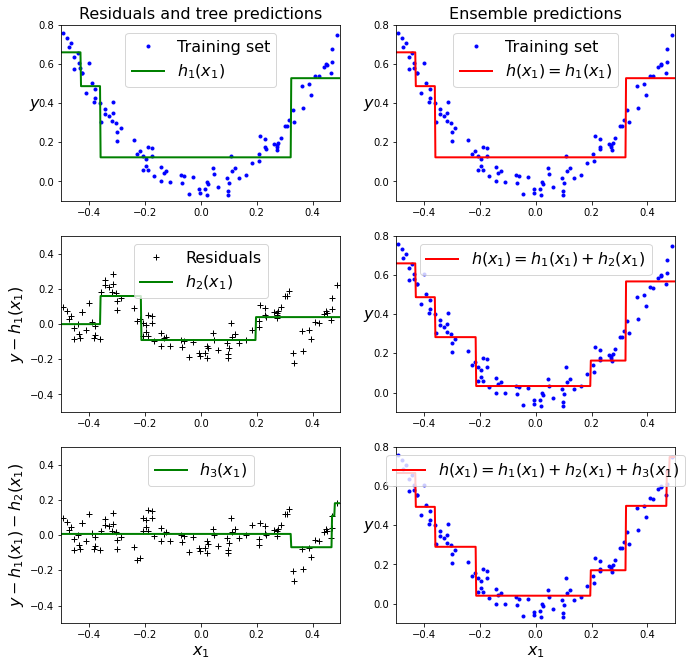

In [14]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [15]:

df = pd.read_csv('titanic.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [17]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,Cabin,687
1,Age,177
2,Embarked,2


In [18]:
df1 = df.dropna()


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [19]:
dfo=df1.select_dtypes(exclude=['int64','float64'])

**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [20]:
df = pd.DataFrame(df1.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(183, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [21]:
na_df=pd.DataFrame(df1.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**
**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [22]:
from sklearn.model_selection import train_test_split
X=df.drop(['Survived'], axis=1)

y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=246)

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [23]:
#scaler = preprocessing.StandardScaler().fit(X)
#X_scaled =


#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [24]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb =GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_scaled, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_scaled, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.752
Accuracy score (validation): 0.717

Learning rate:  0.1
Accuracy score (training): 0.745
Accuracy score (validation): 0.717

Learning rate:  0.25
Accuracy score (training): 0.715
Accuracy score (validation): 0.630

Learning rate:  0.5
Accuracy score (training): 0.715
Accuracy score (validation): 0.630

Learning rate:  0.75
Accuracy score (training): 0.664
Accuracy score (validation): 0.587

Learning rate:  1
Accuracy score (training): 0.584
Accuracy score (validation): 0.565



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [25]:
#The best learning rate is 0.5
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_scaled, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test_scaled, y_test)))
print()

Learning rate:  1
Accuracy score (training): 0.752
Accuracy score (validation): 0.717



In [26]:
y_pred=gb.predict(X_test_scaled)

In [27]:
df.Survived.unique()

array([1, 0])

Confusion Matrix

Confusion matrix, without normalization
[[ 8  7]
 [ 6 25]]
Normalized confusion matrix
[[0.53 0.47]
 [0.19 0.81]]


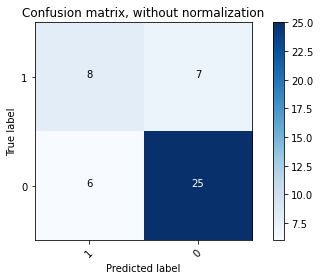

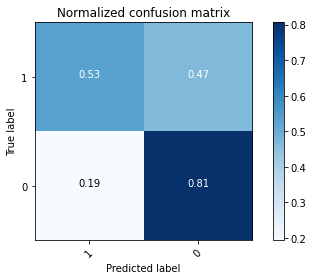

In [28]:
class_names=[1,0]
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

In [29]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install xgboost-0.6-cp35-cp35m-win_amd64.whl

ERROR: xgboost-0.6-cp35-cp35m-win_amd64.whl is not a supported wheel on this platform.
Note: you may need to restart the kernel to use updated packages.


**<font color='teal'>Calculate the ROC for the model as well.</font>**

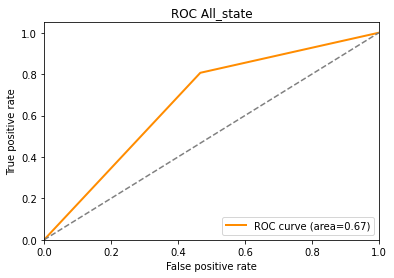

done


In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


fpr = dict()
tpr = dict()
roc_auc = dict()
#a dictionary is initialised for the false positive rate and true positive rate
#plus the roc_ area under the curve 
#fpr is the false positve rate and tpr is the true positive rate

fpr[0],tpr[0],_ = roc_curve(y_test, y_pred)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC All_state')
plt.legend(loc='lower right')
plt.show()

print('done')

In [35]:
print(len(y_pred))
print(len(y_test))

46
46


In [33]:

from xgboost.sklearn import XGBClassifier
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
gb1 = XGBClassifier(max_depth=2,learning_rate = 0.05)
gb1.fit(X_train, y_train)
rocauc = ROCAUC(gb1, size=(1080, 720), classes=class_names)

rocauc.score(X_test, y_test)  
r = rocauc.poof()

ModuleNotFoundError: No module named 'xgboost'

In [42]:
# Import the classifiers
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

# Instantiate the classfiers and make a list
classifiers = [GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=2, max_depth = 2, random_state = 0), 
               GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_features=2, max_depth = 2, random_state = 0), 
               GradientBoostingClassifier(n_estimators=20, learning_rate = 0.25, max_features=2, max_depth = 2, random_state = 0), 
               GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0),
               GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 2, random_state = 0),
               GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)



In [43]:
result_table

,fpr,tpr,auc
classifiers,,,
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.06666666666666667, 0.0666666...","[0.0, 0.0967741935483871, 0.16129032258064516,...",0.824731
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.06666666666666667, 0.0666666...","[0.0, 0.0967741935483871, 0.16129032258064516,...",0.821505
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...","[0.0, 0.03225806451612903, 0.0967741935483871,...",0.833333
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...","[0.0, 0.0967741935483871, 0.16129032258064516,...",0.844086
GradientBoostingClassifier,"[0.0, 0.0, 0.06666666666666667, 0.066666666666...","[0.0, 0.0967741935483871, 0.0967741935483871, ...",0.810753
GradientBoostingClassifier,"[0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...","[0.0, 0.03225806451612903, 0.16129032258064516...",0.791398


In [52]:
result_table['Lr'] = learning_rates
#output = result_table.append(learning_rate, ignore_index=True)
print(result_table)

                                                                          fpr  \
classifiers                                                                     
GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.06666666666666667, 0.0666666...   
GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.06666666666666667, 0.0666666...   
GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...   
GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...   
GradientBoostingClassifier  [0.0, 0.0, 0.06666666666666667, 0.066666666666...   
GradientBoostingClassifier  [0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06...   

                                                                          tpr  \
classifiers                                                                     
GradientBoostingClassifier  [0.0, 0.0967741935483871, 0.16129032258064516,...   
GradientBoostingClassifier  [0.0, 0.0967741935483871, 0.16129032258064516,...   
GradientBoostingClassifier 

In [65]:
result_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, GradientBoostingClassifier to GradientBoostingClassifier
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fpr     6 non-null      object 
 1   tpr     6 non-null      object 
 2   auc     6 non-null      float64
 3   Lr      6 non-null      float64
dtypes: float64(2), object(2)
memory usage: 240.0+ bytes


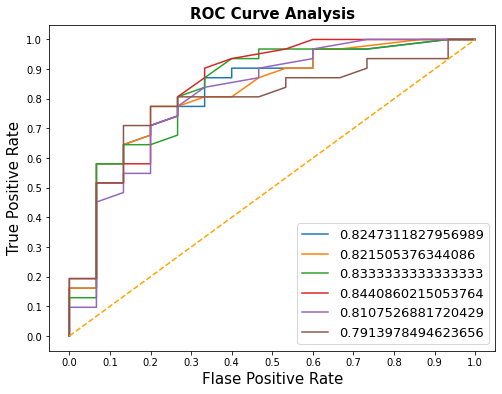

In [83]:

fig = plt.figure(figsize=(8,6))

for i in range(len(result_table)):
    plt.plot(result_table.iloc[i]['fpr'],result_table.iloc[i]['tpr'],label=result_table.iloc[i]['auc'])
    #label=result_table.iloc[i]['auc'])
             #label="{}, AUC={:.3f}".format(i, result_table.iloc[i]['auc'])))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

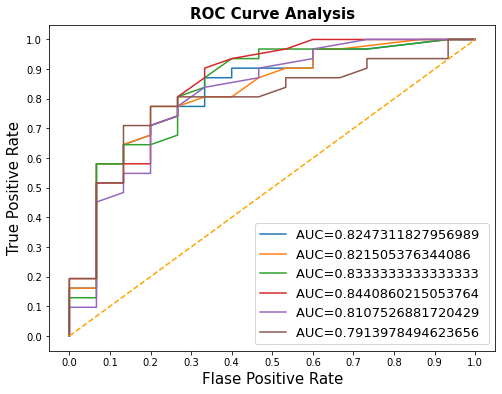

In [59]:


fig = plt.figure(figsize=(8,6))

for i in range(len(result_table)):
    plt.plot(result_table.iloc[i]['fpr'],result_table.iloc[i]['tpr'],label='AUC=%s '%result_table.iloc[i]['auc'])
    #label=result_table.iloc[i]['auc']
             #label="{}, AUC={:.3f}".format(i, result_table.iloc[i]['auc'])))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [68]:


fig = plt.figure(figsize=(8,6))

for i in range(len(result_table)):
    plt.plot(result_table.iloc[i]['fpr'],result_table.iloc[i]['tpr'],label='LR=%0.2f'%result_table.iloc[i]['Lr']%'AUC=%s '%result_table.iloc[i]['auc'])
    #label=result_table.iloc[i]['auc']
             #label="{}, AUC={:.3f}".format(i, result_table.iloc[i]['auc'])))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

TypeError: not all arguments converted during string formatting

<Figure size 576x432 with 0 Axes>

In [69]:
result_table.iloc[1]['Lr']

0.1